<a href="https://colab.research.google.com/github/LouisLortie/colab/blob/main/ecse_551_assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
#@title Import list

# from google.colab import drive                    # Need to activate this if using Google Colab (with drive)
import csv
import pandas as pd, numpy as np
import matplotlib.pyplot as plt

In [53]:
# Function that counts the number of features
def feature_count(data):
  return data.shape[1] - 1         # The last column is the class label

# Function that separates the input and output data
def get_xy_data(data):
    x = data[:,:-1]
    y = data[:,-1].reshape(-1,1)
    return x, y


In [54]:
# Function that classifies the training data into the two binary classes
def data_separation(data):

  count_pos = 0
  count_neg = 0
  
  for i in range(data.shape[0]) :      # all rows of data

    if data[i, -1] == 0 :
      if count_neg == 0 :
        data_neg = data[[i], :]
      else :
        data_neg = np.concatenate((data_neg, data[[i], :]), axis=0)
      count_neg += 1

    elif data[i, -1] == 1 :
      if count_pos == 0 :
        data_pos = data[[i], :]
      else :
        data_pos = np.concatenate((data_pos, data[[i], :]), axis=0)
      count_pos += 1

  return data_pos, data_neg

In [59]:
#@title Load CSV

# drive.mount('/content/drive')                    # Activate on drive
# Reading air quality data
# aq_csv = pd.read_csv("/content/drive/MyDrive/ecse_551/assignment1/air_quality.csv")                 # Active on drive
aq_csv = pd.read_csv("air_quality.csv") 

# Reading liver patient data
# lp_csv = pd.read_csv("/content/drive/MyDrive/ecse_551/assignment1/liver_patient.csv")               # Active on drive
lp_csv = pd.read_csv("liver_patient.csv") 

# Array
aq_data = np.array(aq_csv)
lp_data = np.array(lp_csv)

# Divide into inputs and outputs
aq_x, aq_y = get_xy_data(aq_data)
lp_x, lp_y = get_xy_data(lp_data)

In [58]:
#@title Setting rcParams
plt.style.use('classic')
plt.rcParams.update({
                        #  "text.usetex": True,
                        #  "font.family": "serif",
                        #  "font.sans-serif": ["Times"],
                         "lines.linewidth" : 3,
                         "font.size" : 12,
                         "figure.constrained_layout.use" : True,
                         "hist.bins" : 100 
                         })

In [60]:
# Machine learning method: Classicifiation Discriminative learning
class DiscriminativeLearning():

    def __init__(self, x, y, step_size, epsilon):
        self.x = np.insert(x, 0, 1, axis=1)
        self.y = y
        self.step_size = step_size
        self.epsilon = epsilon
        self.w0 = np.zeros((self.x.shape[1], 1))
    
    def logistic_function(self, w, xi):
        a = w.T @ xi
        s = 1 / (1 + np.exp(-a))
        return s

    def fit(self):
        delta = 0
        w_old = self.w0
        w_new = w_old
        while True:
            w_old = w_new
            for i in range(self.x.shape[0]):
                xi = self.x[i].reshape(-1,1)
                yi = self.y[i]
                delta = delta - xi @ (yi - self.logistic_function(w_old, xi))
            w_new = w_old - self.step_size * delta
            error = np.linalg.norm(w_new - w_old, ord =2)
            print(error)
            if error < self.epsilon:
                break
        return w_new

    def predict(self, w, x):
        x = np.insert(x, 0, 1, axis=1)
        p = w.T @ x
        if p > 0.5:
            y = 1
        elif p == 0.5:
            # randomly choose 0 or 1
            y = np.random.randint(0,2)
        else:
            y = 0
        return y

In [ ]:
#@title Generativelearning class: Generative model for binary classification

class GenerativeLearning():

  def __init__(self, data):
    self.data = data
    self.data_pos, self.data_neg = data_separation(data)
    self.feat_count = feature_count(self.data)
    self.pos_count = self.data_pos.shape[0]
    self.neg_count = self.data_neg.shape[0]
    self.pos_prior = self.pos_count / self.data.shape[0]
    self.neg_prior = self.neg_count / self.data.shape[0]
    self.pos_mean = np.mean(self.data_pos[:,:-1], axis=0)
    self.neg_mean = np.mean(self.data_neg[:,:-1], axis=0)

    # Notice the difference in the covariance matrix calculation
    self.cov = ((self.data_pos[:,:-1] - self.pos_mean).T @ (self.data_pos[:,:-1] - self.pos_mean) + (self.data_neg[:,:-1] - self.neg_mean).T @ (self.data_neg[:,:-1] - self.neg_mean)) / (self.pos_count + self.neg_count - 2)
    self.cov_pos = (self.data_pos[:,:-1] - self.pos_mean).T @ (self.data_pos[:,:-1] - self.pos_mean) / (self.pos_count - 1)
    self.cov_neg = (self.data_neg[:,:-1] - self.neg_mean).T @ (self.data_neg[:,:-1] - self.neg_mean) / (self.neg_count - 1)
    

  def fit_lda_linear(self):

    self.w0 = np.log(self.pos_prior) - np.log(self.neg_prior) - 0.5 * self.pos_mean .T @ np.linalg.inv(self.cov) @ self.pos_mean + 0.5 * self.neg_mean .T @ np.linalg.inv(self.cov) @ self.neg_mean
    self.w1 = np.linalg.inv(self.cov) @ (self.pos_mean - self.neg_mean)
    self.w = np.concatenate((self.w0.reshape(1,), self.w1))

    return self.w


  def fit_lda_quadratic(self):      # Should be fine, but has not been tested out
      
      self.w0 = np.log(self.pos_prior) - np.log(self.neg_prior) - 0.5 * self.pos_mean .T @ np.linalg.inv(self.cov_pos) @ self.pos_mean + 0.5 * self.neg_mean .T @ np.linalg.inv(self.cov_neg) @ self.neg_mean - 0.5 * np.log(np.linalg.det(self.cov_pos)) + 0.5 * np.log(np.linalg.det(self.cov_neg))
      self.w1 = np.linalg.inv(self.cov_pos) @ self.pos_mean - np.linalg.inv(self.cov_neg) @ self.neg_mean
      self.w2 = -0.5 * np.linalg.inv(self.cov_neg) + 0.5 * np.linalg.inv(self.cov_pos)
      self.w = np.concatenate((self.w0.reshape(1,), self.w1, self.w2))
  
      return self.w
  


  def predict(self, x):

    self.y = x @ self.w[1:] + self.w[0]
    
    return self.y

In [ ]:

#@title augment_ones function: Function that augments the data with a column of ones
def augment_ones(data):
    ones = np.ones((data.shape[0], 1))
    return np.concatenate((data, ones), axis=1)

In [ ]:

#@title increase_complexity function: Function that increases the complexity of the data
def increase_complexity(data):
    # data = augment_ones(data)                                    # could be used to augment the data with a column of ones
    data = np.concatenate((data, data[:, :-1]**2), axis=1)         # Here, we augment the data with a column of squares of the features
    return data

In [ ]:

#@title plot hist: Function that plots the histogram of one feature
# The number of bins can be changed via rcParams above.

def plot_hist(feat_pos, feat_neg, feat_num):
  fig, ax = plt.subplots(2, 1, sharex=True)
  ax[0].hist(feat_pos, color="b", label=r"Class y = 1")
  ax[1].hist(feat_neg, color="r", label=r"Class y = 0")
  ax[0].set_title("Feature %i distribution comparison between classes" %(feat_num + 1))
  ax[0].legend(loc='upper right')
  ax[1].legend(loc='upper right')
  plt.tight_layout

  return 0

In [ ]:
#@title plot_regression: Function that plots the regression line

def plot_regression(x, y, w, feature_num):    # Where x is the domain to which the regression line is to be plotted and i the feature number
    
    range = np.arange(np.min(x), np.max(x), 1/y.shape[0])
    
    fig, ax = plt.subplots(1, 1)
    ax.scatter(x, y, color="b", label=r"Prediction")
    ax.plot(range, w[feature_num+1] * range + w[0], color="r", label=r"Regression line")    # Because w[0] is the bias term
    ax.set_title("Feature %i regression" %(feature_num + 1))
    ax.legend(loc='upper right')
    plt.tight_layout
    
    return 0

In [ ]:

#@title fold_prep: Separates data into testing, validation and testing sets
def fold_prep(data, train_num, validation_num, test_num):
    # np.random.shuffle(data)
    data_train = data[:train_num, :]
    data_val = data[train_num:train_num+validation_num, :]
    data_test = data[train_num+validation_num:train_num+validation_num+test_num, :]
    return data_train, data_val, data_test

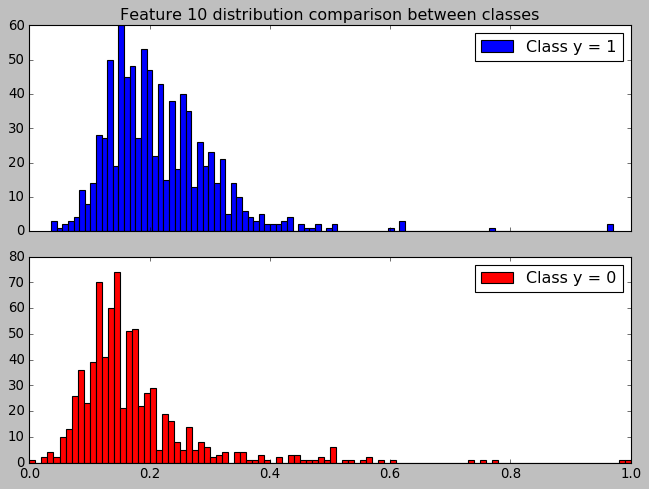

In [61]:
#@title Main function
def main():

  feat = 9   # Feature to analyse.

  data_pos, data_neg = data_separation(aq_data)
  
  plot_hist(data_pos[:, feat], data_neg[:, feat], feat)

  # Divide into inputs and outputs
  aq_x, aq_y = get_xy_data(aq_data)
  lp_x, lp_y = get_xy_data(lp_data)
  # aq_dl = DiscriminativeLearning(aq_x, aq_y, 0.001, 0.01)
  lp_dl = DiscriminativeLearning(lp_x, lp_y, 0.001, 0.01)
  # w1 = aq_dl.fit()
  w2 = lp_dl.fit()
  print(w2)
  
if __name__ == '__main__':
    main()